In [58]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os

In [59]:
class MomentumStrategy:
    def __init__(self, price_data, leverage=1, initial_portfolio_value=10000):
        """
        Initialize the MomentumStrategy.

        Parameters:
        - price_data (DataFrame): DataFrame with timestamp indexed asset prices.
        - leverage (float): Leverage factor for trades.
        - initial_portfolio_value (float): Starting portfolio value.
        """
        self.price_data = price_data.copy()
        self.leverage = leverage
        self.initial_portfolio_value = initial_portfolio_value
        # Initialize separate trade logs for each slope method
        self.trade_logs_percentage = {asset: pd.DataFrame(columns=['timestamp', 'type', 'price', 'slope', 'return']) 
                                      for asset in self.price_data.columns if asset != 'time'}
        self.trade_logs_normalized = {asset: pd.DataFrame(columns=['timestamp', 'type', 'price', 'slope', 'return']) 
                                      for asset in self.price_data.columns if asset != 'time'}

    # ----------------------------
    # Slope Calculation Methods
    # ----------------------------

    def calculate_moving_avg(self, price_series, window):
        """
        Calculate the moving average of the price series.

        Parameters:
        - price_series (Series): Asset price series.
        - window (int): Window size for moving average.

        Returns:
        - Series: Moving average series.
        """
        return price_series.rolling(window=window).mean()

    def calculate_percentage_slope(self, moving_avg_series):
        """
        Calculate the percentage slope of the moving average.

        Parameters:
        - moving_avg_series (Series): Moving average series.

        Returns:
        - Series: Percentage slope values.
        """
        slope = (moving_avg_series.diff(1) / moving_avg_series.shift(1)) * 100
        slope = slope.fillna(0)  # Replace NaN values with 0
        return slope

    def calculate_slope(self, moving_avg_series, window):
        """
        Calculate the slope of the moving average.

        Parameters:
        - moving_avg_series (Series): Moving average series.
        - window (int): Window size for slope calculation.

        Returns:
        - Series: Slope as a percentage change.
        """
        # Calculate percent change over the window to standardize slope
        slope = (moving_avg_series.diff(window) / moving_avg_series.shift(1)) * 100
        slope = slope.fillna(0)  # Replace NaN values with 0
        return slope  # Slope as a percentage change

    def normalize_slope(self, slope_series, window):
        """
        Normalize the slope to be between -1 and 1 using Min-Max Normalization.

        Parameters:
        - slope_series (Series): Slope series.
        - window (int): Rolling window size for normalization.

        Returns:
        - Series: Normalized slope series.
        """
        min_slope = slope_series.rolling(window=window, min_periods=1).min()
        max_slope = slope_series.rolling(window=window, min_periods=1).max()
        
        # Prevent division by zero
        denom = max_slope - min_slope
        denom = denom.replace(0, 1)  # Replace 0 with 1 to avoid division by zero
        
        normalized_slope = 2 * (slope_series - min_slope) / denom - 1
        normalized_slope = normalized_slope.fillna(0)  # Handle NaN values
        return normalized_slope

    # ----------------------------
    # Trade Simulation Methods
    # ----------------------------

    def simulate_trade_with_percentage_slope(self, market, position_size, entry_threshold, exit_threshold, window):
        """
        Simulate trading for a single market using percentage-based slope values and record trade returns.

        Parameters:
        - market (str): Market identifier (column name in price_data).
        - position_size (float): Size of each position.
        - entry_threshold (float): Threshold for entering trades.
        - exit_threshold (float): Threshold for exiting trades.
        - window (int): Window size for moving average and slope calculation.

        Returns:
        - float: Final portfolio value after trading.
        """
        price_series = self.price_data[market]
        moving_avg_series = self.calculate_moving_avg(price_series, window)
        slope_series = self.calculate_percentage_slope(moving_avg_series)

        # Handle NaN values by filling forward or setting to zero
        slope_series = slope_series.fillna(0)

        # Initialize portfolio values tracking
        portfolio_value = self.initial_portfolio_value
        in_position = False
        position_type = None  # "long" or "short"
        entry_price = 0.0

        for idx in range(len(self.price_data)):
            current_slope = slope_series.iloc[idx]
            current_price = price_series.iloc[idx]
            current_time = slope_series.index[idx]

            # Entry Conditions
            if not in_position:
                # Long Entry
                if current_slope >= entry_threshold:
                    in_position = True
                    position_type = "long"
                    entry_price = current_price
                    # Log the trade
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'long_entry',
                        'price': entry_price,
                        'slope': current_slope,
                        'return': np.nan  # Placeholder for exit return
                    }])
                    self.trade_logs_percentage[market] = pd.concat([self.trade_logs_percentage[market], new_row], ignore_index=True)

                # Short Entry
                elif current_slope <= -entry_threshold:
                    in_position = True
                    position_type = "short"
                    entry_price = current_price
                    # Log the trade
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'short_entry',
                        'price': entry_price,
                        'slope': current_slope,
                        'return': np.nan  # Placeholder for exit return
                    }])
                    self.trade_logs_percentage[market] = pd.concat([self.trade_logs_percentage[market], new_row], ignore_index=True)

            # Exit Conditions
            else:
                if position_type == "long" and current_slope <= exit_threshold:
                    # Calculate price change
                    price_change = (current_price - entry_price) / entry_price
                    leveraged_return = price_change * position_size * self.leverage
                    # Assume a trading fee (e.g., 0.1%)
                    trading_fee = position_size * self.leverage * 0.001
                    trade_return = leveraged_return - trading_fee
                    portfolio_value += trade_return
                    # Log the trade exit with return
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'long_exit',
                        'price': current_price,
                        'slope': current_slope,
                        'return': trade_return
                    }])
                    self.trade_logs_percentage[market] = pd.concat([self.trade_logs_percentage[market], new_row], ignore_index=True)
                    # Reset position
                    in_position, position_type, entry_price = False, None, None

                elif position_type == "short" and current_slope >= -exit_threshold:
                    # Calculate price change for short
                    price_change = (entry_price - current_price) / entry_price
                    leveraged_return = price_change * position_size * self.leverage
                    # Assume a trading fee (e.g., 0.1%)
                    trading_fee = position_size * self.leverage * 0.001
                    trade_return = leveraged_return - trading_fee
                    portfolio_value += trade_return
                    # Log the trade exit with return
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'short_exit',
                        'price': current_price,
                        'slope': current_slope,
                        'return': trade_return
                    }])
                    self.trade_logs_percentage[market] = pd.concat([self.trade_logs_percentage[market], new_row], ignore_index=True)
                    # Reset position
                    in_position, position_type, entry_price = False, None, None

        # Exiting the last open position at the end of the data
        if in_position:
            final_price = price_series.iloc[-1]
            final_time = slope_series.index[-1]
            if position_type == "long":
                price_change = (final_price - entry_price) / entry_price
                trade_type = 'long_exit'
            elif position_type == "short":
                price_change = (entry_price - final_price) / entry_price
                trade_type = 'short_exit'
            leveraged_return = price_change * position_size * self.leverage
            trading_fee = position_size * self.leverage * 0.001
            trade_return = leveraged_return - trading_fee
            portfolio_value += trade_return
            # Log the trade exit with return
            new_row = pd.DataFrame([{
                'timestamp': final_time,
                'type': trade_type,
                'price': final_price,
                'slope': slope_series.iloc[-1],
                'return': trade_return
            }])
            self.trade_logs_percentage[market] = pd.concat([self.trade_logs_percentage[market], new_row], ignore_index=True)

        return portfolio_value

    def simulate_trade_with_normalized_slope(self, market, position_size, entry_threshold, exit_threshold, window):
        """
        Simulate trading for a single market using normalized slope values and record trade returns.

        Parameters:
        - market (str): Market identifier (column name in price_data).
        - position_size (float): Size of each position.
        - entry_threshold (float): Threshold for entering trades.
        - exit_threshold (float): Threshold for exiting trades.
        - window (int): Window size for moving average and slope calculation.

        Returns:
        - float: Final portfolio value after trading.
        """
        price_series = self.price_data[market]
        moving_avg_series = self.calculate_moving_avg(price_series, window)
        slope_series = self.normalize_slope(self.calculate_slope(moving_avg_series, window), window)

        # Handle NaN values by filling forward or setting to zero
        slope_series = slope_series.fillna(0)

        # Initialize portfolio values tracking
        portfolio_value = self.initial_portfolio_value
        in_position = False
        position_type = None  # "long" or "short"
        entry_price = 0.0

        for idx in range(len(self.price_data)):
            current_slope = slope_series.iloc[idx]
            current_price = price_series.iloc[idx]
            current_time = slope_series.index[idx]

            # Entry Conditions
            if not in_position:
                # Long Entry
                if current_slope >= entry_threshold:
                    in_position = True
                    position_type = "long"
                    entry_price = current_price
                    # Log the trade
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'long_entry',
                        'price': entry_price,
                        'slope': current_slope,
                        'return': np.nan  # Placeholder for exit return
                    }])
                    self.trade_logs_normalized[market] = pd.concat([self.trade_logs_normalized[market], new_row], ignore_index=True)

                # Short Entry
                elif current_slope <= -entry_threshold:
                    in_position = True
                    position_type = "short"
                    entry_price = current_price
                    # Log the trade
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'short_entry',
                        'price': entry_price,
                        'slope': current_slope,
                        'return': np.nan  # Placeholder for exit return
                    }])
                    self.trade_logs_normalized[market] = pd.concat([self.trade_logs_normalized[market], new_row], ignore_index=True)

            # Exit Conditions
            else:
                if position_type == "long" and current_slope <= exit_threshold:
                    # Calculate price change
                    price_change = (current_price - entry_price) / entry_price
                    leveraged_return = price_change * position_size * self.leverage
                    # Assume a trading fee (e.g., 0.1%)
                    trading_fee = position_size * self.leverage * 0.001
                    trade_return = leveraged_return - trading_fee
                    portfolio_value += trade_return
                    # Log the trade exit with return
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'long_exit',
                        'price': current_price,
                        'slope': current_slope,
                        'return': trade_return
                    }])
                    self.trade_logs_normalized[market] = pd.concat([self.trade_logs_normalized[market], new_row], ignore_index=True)
                    # Reset position
                    in_position, position_type, entry_price = False, None, None

                elif position_type == "short" and current_slope >= -exit_threshold:
                    # Calculate price change for short
                    price_change = (entry_price - current_price) / entry_price
                    leveraged_return = price_change * position_size * self.leverage
                    # Assume a trading fee (e.g., 0.1%)
                    trading_fee = position_size * self.leverage * 0.001
                    trade_return = leveraged_return - trading_fee
                    portfolio_value += trade_return
                    # Log the trade exit with return
                    new_row = pd.DataFrame([{
                        'timestamp': current_time,
                        'type': 'short_exit',
                        'price': current_price,
                        'slope': current_slope,
                        'return': trade_return
                    }])
                    self.trade_logs_normalized[market] = pd.concat([self.trade_logs_normalized[market], new_row], ignore_index=True)
                    # Reset position
                    in_position, position_type, entry_price = False, None, None

        # Exiting the last open position at the end of the data
        if in_position:
            final_price = price_series.iloc[-1]
            final_time = slope_series.index[-1]
            if position_type == "long":
                price_change = (final_price - entry_price) / entry_price
                trade_type = 'long_exit'
            elif position_type == "short":
                price_change = (entry_price - final_price) / entry_price
                trade_type = 'short_exit'
            leveraged_return = price_change * position_size * self.leverage
            trading_fee = position_size * self.leverage * 0.001
            trade_return = leveraged_return - trading_fee
            portfolio_value += trade_return
            # Log the trade exit with return
            new_row = pd.DataFrame([{
                'timestamp': final_time,
                'type': trade_type,
                'price': final_price,
                'slope': slope_series.iloc[-1],
                'return': trade_return
            }])
            self.trade_logs_normalized[market] = pd.concat([self.trade_logs_normalized[market], new_row], ignore_index=True)

        return portfolio_value

    # ----------------------------
    # Trade Aggregation Methods
    # ----------------------------

    def trade_all_markets_with_percentage_slope(self, window, position_size, entry_threshold, exit_threshold):
        """
        Simulate trading across all markets using percentage-based slope values.

        Parameters:
        - window (int): Window size for moving average and slope calculation.
        - position_size (float): Size of each position.
        - entry_threshold (float): Threshold for entering trades.
        - exit_threshold (float): Threshold for exiting trades.

        Returns:
        - float: Aggregate returns across all markets.
        """
        total_returns = 0.0
        for market in self.price_data.columns:
            if market == 'time':
                continue

            final_portfolio = self.simulate_trade_with_percentage_slope(
                market=market,
                position_size=position_size,
                entry_threshold=entry_threshold,
                exit_threshold=exit_threshold,
                window=window
            )
            returns = final_portfolio - self.initial_portfolio_value
            total_returns += returns

        return total_returns

    def trade_all_markets_with_normalized_slope(self, window, position_size, entry_threshold, exit_threshold):
        """
        Simulate trading across all markets using normalized slope values.

        Parameters:
        - window (int): Window size for moving average and slope calculation.
        - position_size (float): Size of each position.
        - entry_threshold (float): Threshold for entering trades.
        - exit_threshold (float): Threshold for exiting trades.

        Returns:
        - float: Aggregate returns across all markets.
        """
        total_returns = 0.0
        for market in self.price_data.columns:
            if market == 'time':
                continue

            final_portfolio = self.simulate_trade_with_normalized_slope(
                market=market,
                position_size=position_size,
                entry_threshold=entry_threshold,
                exit_threshold=exit_threshold,
                window=window
            )
            returns = final_portfolio - self.initial_portfolio_value
            total_returns += returns

        return total_returns

    # ----------------------------
    # Monte Carlo Simulation Methods
    # ----------------------------

    def run_monte_carlo_simulation_with_percentage_slope(self, iterations, window_range, entry_threshold_range, exit_threshold_range, output_name, save_path='simulation_results'):
        """
        Run Monte Carlo simulations using percentage-based slope values.

        Parameters:
        - iterations (int): Number of simulation iterations.
        - window_range (tuple): Tuple indicating the range (min, max) for window sizes.
        - entry_threshold_range (tuple): Tuple indicating the range (min, max) for entry thresholds.
        - exit_threshold_range (tuple): Tuple indicating the range (min, max) for exit thresholds.
        - output_name (str): Base name for the output JSON file.
        - save_path (str): Directory path to save simulation results.

        Returns:
        - list: List of simulation result dictionaries.
        """
        simulation_results = []

        # Create directory if it doesn't exist
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for i in range(iterations):
            WINDOW = np.random.randint(*window_range)
            POSITION_SIZE = 1
            ENTRY_THRESHOLD = np.random.uniform(*entry_threshold_range)
            EXIT_THRESHOLD = np.random.uniform(*exit_threshold_range)
            total_returns = self.trade_all_markets_with_percentage_slope(
                window=WINDOW,
                position_size=POSITION_SIZE,
                entry_threshold=ENTRY_THRESHOLD,
                exit_threshold=EXIT_THRESHOLD
            )
            simulation_results.append({
                'returns': total_returns,
                'window': WINDOW,
                'position_size': POSITION_SIZE,
                'entry_threshold': ENTRY_THRESHOLD,
                'exit_threshold': EXIT_THRESHOLD
            })
            if (i+1) % 10 == 0 or (i+1) == iterations:
                print(f"Completed {i+1}/{iterations} simulations.")

        # Save all simulation results to a JSON file
        with open(os.path.join(save_path, f'{output_name}_percentage_slope_simulation_results.json'), 'w') as f:
            json.dump(simulation_results, f, indent=4)

        return simulation_results

    def run_monte_carlo_simulation_with_normalized_slope(self, iterations, window_range, entry_threshold_range, exit_threshold_range, output_name, save_path='simulation_results'):
        """
        Run Monte Carlo simulations using normalized slope values.

        Parameters:
        - iterations (int): Number of simulation iterations.
        - window_range (tuple): Tuple indicating the range (min, max) for window sizes.
        - entry_threshold_range (tuple): Tuple indicating the range (min, max) for entry thresholds.
        - exit_threshold_range (tuple): Tuple indicating the range (min, max) for exit thresholds.
        - output_name (str): Base name for the output JSON file.
        - save_path (str): Directory path to save simulation results.

        Returns:
        - list: List of simulation result dictionaries.
        """
        simulation_results = []

        # Create directory if it doesn't exist
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for i in range(iterations):
            WINDOW = np.random.randint(*window_range)
            POSITION_SIZE = 1
            ENTRY_THRESHOLD = np.random.uniform(*entry_threshold_range)
            EXIT_THRESHOLD = np.random.uniform(*exit_threshold_range)
            total_returns = self.trade_all_markets_with_normalized_slope(
                window=WINDOW,
                position_size=POSITION_SIZE,
                entry_threshold=ENTRY_THRESHOLD,
                exit_threshold=EXIT_THRESHOLD
            )
            simulation_results.append({
                'returns': total_returns,
                'window': WINDOW,
                'position_size': POSITION_SIZE,
                'entry_threshold': ENTRY_THRESHOLD,
                'exit_threshold': EXIT_THRESHOLD
            })
            if (i+1) % 10 == 0 or (i+1) == iterations:
                print(f"Completed {i+1}/{iterations} simulations.")

        # Save all simulation results to a JSON file
        with open(os.path.join(save_path, f'{output_name}_normalized_slope_simulation_results.json'), 'w') as f:
            json.dump(simulation_results, f, indent=4)

        return simulation_results

    # ----------------------------
    # Trade Analysis and Visualization Methods
    # ----------------------------

    def plot_trade_histogram_percentage(self, market, bins=50):
        """
        Plot a histogram of trade profitability for a specified market using percentage-based slope.

        Parameters:
        - market (str): Market identifier.
        - bins (int): Number of bins for the histogram.
        """
        if market not in self.trade_logs_percentage:
            print(f"No trade data available for {market}.")
            return

        trades = self.trade_logs_percentage[market]

        # Pair entries and exits
        trades = trades.sort_values(by='timestamp')
        trades = trades.reset_index(drop=True)

        paired_trades = []
        i = 0
        while i < len(trades) - 1:
            entry = trades.iloc[i]
            exit = trades.iloc[i+1]
            if ((entry.type in ['long_entry', 'short_entry']) and 
                ((entry.type == 'long_entry' and exit.type == 'long_exit') or 
                 (entry.type == 'short_entry' and exit.type == 'short_exit'))):
                # Calculate profitability
                if entry.type == 'long_entry':
                    profit = (exit.price - entry.price) / entry.price * self.leverage * 100  # Percentage
                else:  # short_entry
                    profit = (entry.price - exit.price) / entry.price * self.leverage * 100  # Percentage
                paired_trades.append(profit)
                i += 2
            else:
                i += 1  # Skip unmatched trades

        if not paired_trades:
            print(f"No complete trade pairs to analyze for {market}.")
            return

        # Convert to numpy array for convenience
        paired_trades = np.array(paired_trades)

        # Plot histogram
        plt.figure(figsize=(10, 6))
        plt.hist(paired_trades, bins=bins, color='skyblue', edgecolor='black')
        plt.title(f'Profitability Distribution for Trades in {market} (Percentage Slope)')
        plt.xlabel('Profit/Loss (%)')
        plt.ylabel('Number of Trades')
        plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
        plt.show()

    def plot_trade_histogram_normalized(self, market, bins=50):
        """
        Plot a histogram of trade profitability for a specified market using normalized slope.

        Parameters:
        - market (str): Market identifier.
        - bins (int): Number of bins for the histogram.
        """
        if market not in self.trade_logs_normalized:
            print(f"No trade data available for {market}.")
            return

        trades = self.trade_logs_normalized[market]

        # Pair entries and exits
        trades = trades.sort_values(by='timestamp')
        trades = trades.reset_index(drop=True)

        paired_trades = []
        i = 0
        while i < len(trades) - 1:
            entry = trades.iloc[i]
            exit = trades.iloc[i+1]
            if ((entry.type in ['long_entry', 'short_entry']) and 
                ((entry.type == 'long_entry' and exit.type == 'long_exit') or 
                 (entry.type == 'short_entry' and exit.type == 'short_exit'))):
                # Calculate profitability
                if entry.type == 'long_entry':
                    profit = (exit.price - entry.price) / entry.price * self.leverage
                else:  # short_entry
                    profit = (entry.price - exit.price) / entry.price * self.leverage
                paired_trades.append(profit)
                i += 2
            else:
                i += 1  # Skip unmatched trades

        if not paired_trades:
            print(f"No complete trade pairs to analyze for {market}.")
            return

        # Convert to numpy array for convenience
        paired_trades = np.array(paired_trades)

        # Plot histogram
        plt.figure(figsize=(10, 6))
        plt.hist(paired_trades, bins=bins, color='salmon', edgecolor='black')
        plt.title(f'Profitability Distribution for Trades in {market} (Normalized Slope)')
        plt.xlabel('Profit/Loss (%)')
        plt.ylabel('Number of Trades')
        plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
        plt.show()

    def plot_trade_counts_percentage(self):
        """
        Plot the number of trades per asset using percentage-based slope.
        """
        trade_counts = {market: len(df) // 2 for market, df in self.trade_logs_percentage.items()}  # Each trade has entry and exit
        trade_counts = pd.Series(trade_counts)

        # Plot bar chart
        trade_counts.plot(kind='bar', figsize=(12, 6), color='lightblue', edgecolor='black')
        plt.title('Number of Trades per Asset (Percentage Slope)')
        plt.xlabel('Asset')
        plt.ylabel('Number of Trades')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_trade_counts_normalized(self):
        """
        Plot the number of trades per asset using normalized slope.
        """
        trade_counts = {market: len(df) // 2 for market, df in self.trade_logs_normalized.items()}  # Each trade has entry and exit
        trade_counts = pd.Series(trade_counts)

        # Plot bar chart
        trade_counts.plot(kind='bar', figsize=(12, 6), color='salmon', edgecolor='black')
        plt.title('Number of Trades per Asset (Normalized Slope)')
        plt.xlabel('Asset')
        plt.ylabel('Number of Trades')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # ----------------------------
    # Trade Logging and Saving Methods
    # ----------------------------

    def save_trade_logs_percentage(self, save_path='trade_logs_percentage'):
        """
        Save trade logs for all assets (percentage-based slope) to CSV files.

        Parameters:
        - save_path (str): Directory path to save trade logs.
        """
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for market, df in self.trade_logs_percentage.items():
            if not df.empty:
                df.to_csv(os.path.join(save_path, f'{market}_trade_log_percentage.csv'), index=False)
                print(f"Saved trade log for {market} to {save_path}.")
            else:
                print(f"No trades to save for {market}.")

    def save_trade_logs_normalized(self, save_path='trade_logs_normalized'):
        """
        Save trade logs for all assets (normalized slope) to CSV files.

        Parameters:
        - save_path (str): Directory path to save trade logs.
        """
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for market, df in self.trade_logs_normalized.items():
            if not df.empty:
                df.to_csv(os.path.join(save_path, f'{market}_trade_log_normalized.csv'), index=False)
                print(f"Saved trade log for {market} to {save_path}.")
            else:
                print(f"No trades to save for {market}.")


In [146]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv'), 50, 2000)
params_15m = strategy.run_monte_carlo_simulation_with_normalized_slope(500, (100, 300), (0.26, 1.0), (-0.4, 0.25), 'initial', './')

/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_39115/3611664135.py:287: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs_normalized[market] = pd.concat([self.trade_logs_normalized[market], new_row], ignore_index=True)


Completed 10/500 simulations.
Completed 20/500 simulations.
Completed 30/500 simulations.
Completed 40/500 simulations.
Completed 50/500 simulations.
Completed 60/500 simulations.
Completed 70/500 simulations.
Completed 80/500 simulations.
Completed 90/500 simulations.
Completed 100/500 simulations.
Completed 110/500 simulations.
Completed 120/500 simulations.
Completed 130/500 simulations.
Completed 140/500 simulations.
Completed 150/500 simulations.
Completed 160/500 simulations.
Completed 170/500 simulations.
Completed 180/500 simulations.
Completed 190/500 simulations.
Completed 200/500 simulations.
Completed 210/500 simulations.
Completed 220/500 simulations.
Completed 230/500 simulations.
Completed 240/500 simulations.
Completed 250/500 simulations.
Completed 260/500 simulations.
Completed 270/500 simulations.
Completed 280/500 simulations.
Completed 290/500 simulations.
Completed 300/500 simulations.
Completed 310/500 simulations.
Completed 320/500 simulations.
Completed 330/500

In [147]:
# Load the simulation results
with open('initial_normalized_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Sort the DataFrame by the 'Score' column in descending order
sorted_df = df.sort_values(by='returns', ascending=False)

sorted_df.head(10)

,returns,window,position_size,entry_threshold,exit_threshold
357,1408.245830,142,1,0.450000,-0.295375
367,1379.169270,146,1,0.990259,-0.074728
354,1371.604522,143,1,0.659499,-0.308319
458,1353.262546,146,1,0.647751,-0.065919
215,1340.323598,258,1,0.416636,-0.267511
15,1334.182136,252,1,0.686080,-0.335032
441,1333.526130,146,1,0.975103,0.112099
439,1324.508504,145,1,0.316939,-0.371738
265,1323.826945,144,1,0.675563,-0.294450
240,1321.306612,144,1,0.289765,0.095243


In [150]:
sorted_df.tail(10)

,returns,window,position_size,entry_threshold,exit_threshold
336,-70.740855,107,1,0.779743,-0.107854
94,-85.862893,105,1,0.354342,0.152461
190,-110.298099,104,1,0.564047,0.246166
136,-116.634149,103,1,0.612718,0.169442
35,-157.964401,103,1,0.410345,0.157768
184,-173.549250,102,1,0.303955,-0.158579
292,-186.027288,100,1,0.983256,-0.163515
478,-218.269829,101,1,0.554274,0.126740
23,-218.777504,100,1,0.485008,-0.049320
311,-222.489506,101,1,0.377663,-0.106558


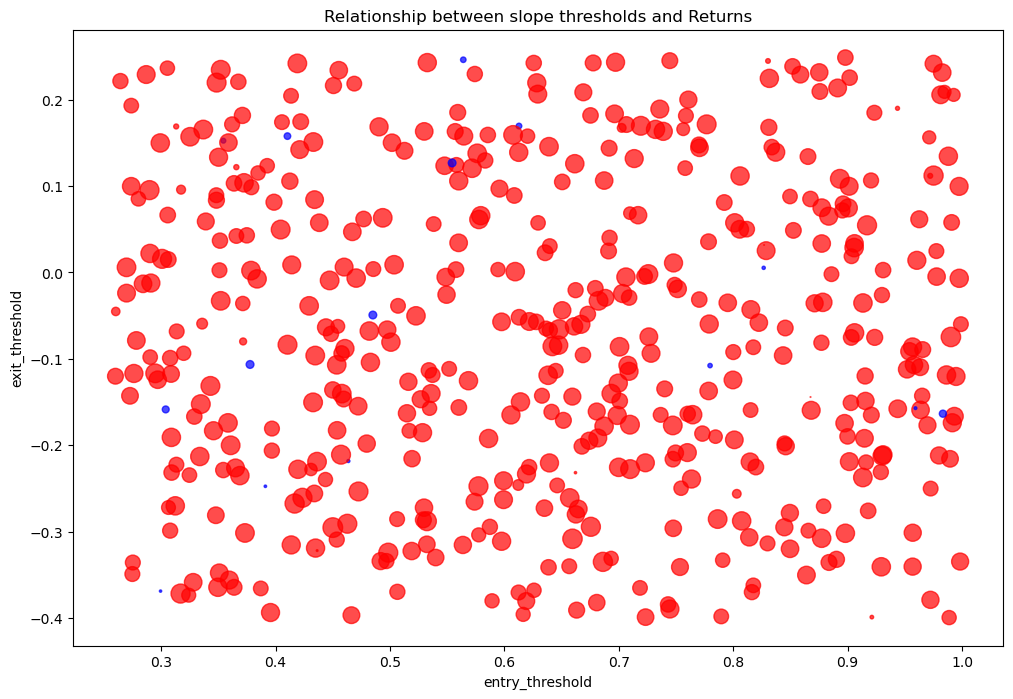

In [148]:
# Load the simulation results
with open('initial_normalized_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Create a column for colors (red for positive, blue for negative)
df['color'] = df['returns'].apply(lambda x: 'red' if x > 0 else 'blue')

# Create a column for size based on the absolute value of returns
df['size'] = df['returns'].abs() / df['returns'].abs().max() * 200  # Normalize sizes to range [0, 200]

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = plt.scatter(
    x=df['entry_threshold'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)

# Add labels and title
plt.title('Relationship between slope thresholds and Returns')
plt.xlabel('entry_threshold')
plt.ylabel('exit_threshold')

plt.show()

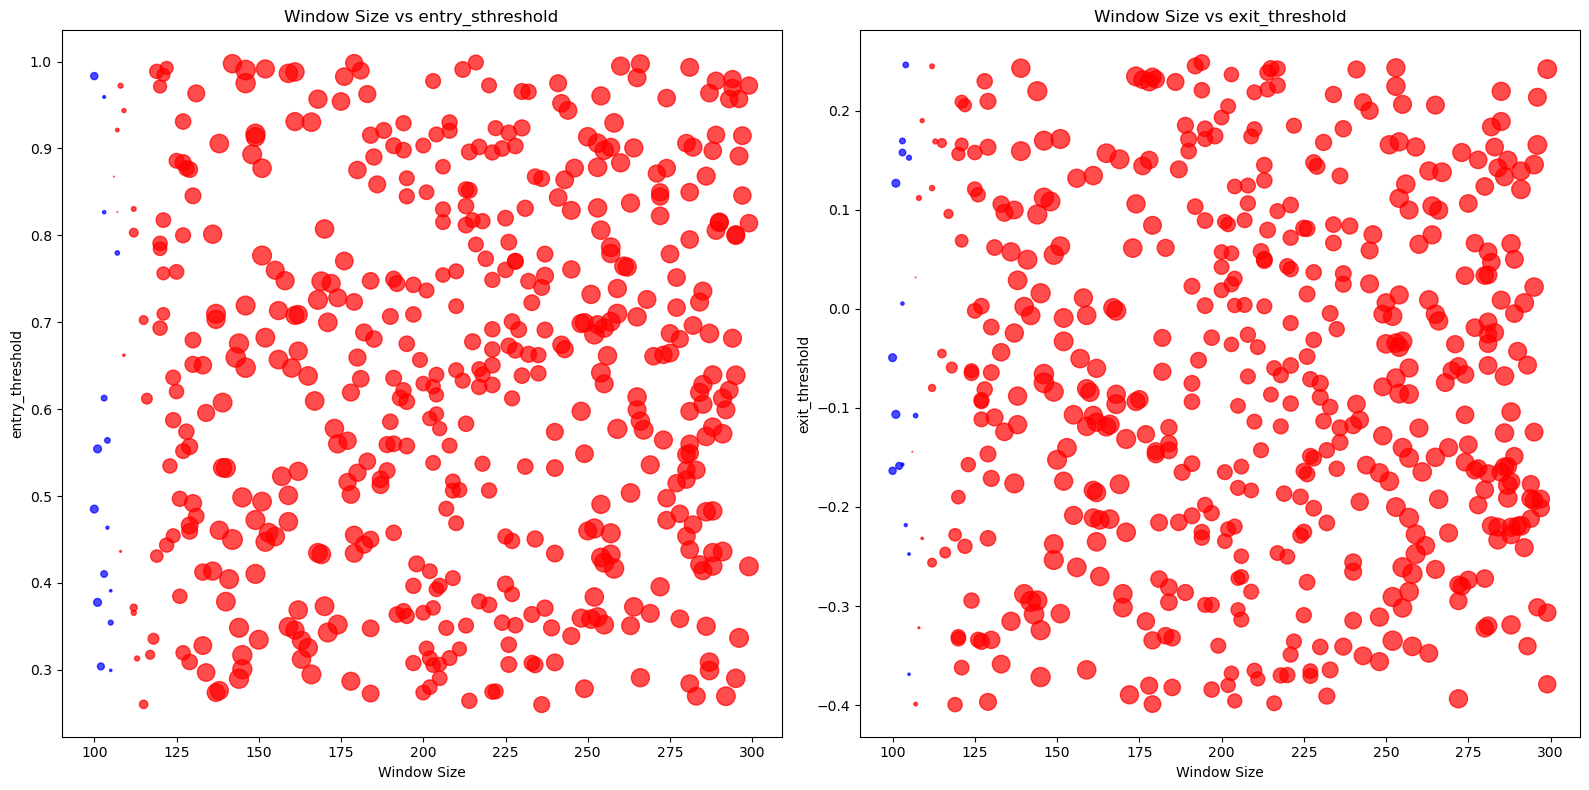

In [149]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# First scatter plot
scatter_plot1 = axes[0].scatter(
    x=df['window'],
    y=df['entry_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[0].set_title('Window Size vs entry_sthreshold')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('entry_threshold')

# Second scatter plot
scatter_plot2 = axes[1].scatter(
    x=df['window'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[1].set_title('Window Size vs exit_threshold')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('exit_threshold')

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()


In [157]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv').tail(5000), 50, 2000)
# Simulate trading
final_portfolio_value = strategy.simulate_trade_with_normalized_slope(
    market='NEARUSDT',
    position_size=1,
    entry_threshold=0.68,
    exit_threshold=-0.33,
    window=250
)

print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")

Final Portfolio Value: $2011.98


/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_39115/3611664135.py:287: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs_normalized[market] = pd.concat([self.trade_logs_normalized[market], new_row], ignore_index=True)


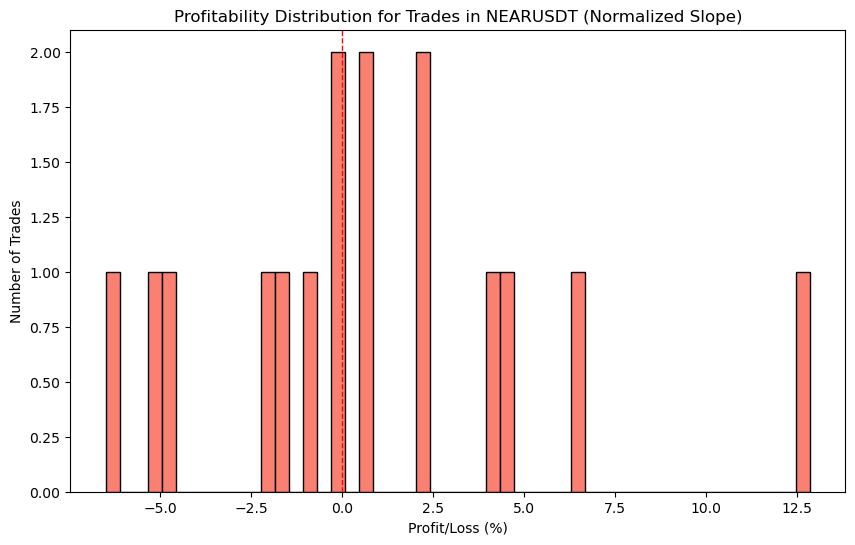

In [158]:
strategy.plot_trade_histogram_normalized('NEARUSDT', bins=50)

In [94]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv').tail(5000), 50, 2000)
params_15m = strategy.run_monte_carlo_simulation_with_normalized_slope(500, (50, 300), (0.26, 1.2), (-0.4, 0.25), 'final', './')

/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_39115/3611664135.py:287: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs_normalized[market] = pd.concat([self.trade_logs_normalized[market], new_row], ignore_index=True)


Completed 10/500 simulations.
Completed 20/500 simulations.
Completed 30/500 simulations.
Completed 40/500 simulations.
Completed 50/500 simulations.
Completed 60/500 simulations.
Completed 70/500 simulations.
Completed 80/500 simulations.
Completed 90/500 simulations.
Completed 100/500 simulations.
Completed 110/500 simulations.
Completed 120/500 simulations.
Completed 130/500 simulations.
Completed 140/500 simulations.
Completed 150/500 simulations.
Completed 160/500 simulations.
Completed 170/500 simulations.
Completed 180/500 simulations.
Completed 190/500 simulations.
Completed 200/500 simulations.
Completed 210/500 simulations.
Completed 220/500 simulations.
Completed 230/500 simulations.
Completed 240/500 simulations.
Completed 250/500 simulations.
Completed 260/500 simulations.
Completed 270/500 simulations.
Completed 280/500 simulations.
Completed 290/500 simulations.
Completed 300/500 simulations.
Completed 310/500 simulations.
Completed 320/500 simulations.
Completed 330/500

In [116]:
# Load the simulation results
with open('final_normalized_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Sort the DataFrame by the 'Score' column in descending order
sorted_df = df.sort_values(by='returns', ascending=False)
#sorted_df[sorted_df['window']< 180].head(10)
sorted_df.head(10)

,returns,window,position_size,entry_threshold,exit_threshold
232,549.036737,249,1,0.759077,-0.284577
91,541.091718,251,1,0.586423,-0.243403
289,535.075005,252,1,0.630913,-0.358516
237,528.753819,253,1,0.754784,-0.108399
254,525.517610,257,1,0.692240,-0.337743
137,518.261665,264,1,0.290408,0.023467
344,517.866004,248,1,0.320457,-0.366973
490,498.627997,266,1,0.838374,0.156204
59,496.999051,250,1,0.372156,-0.274711
464,496.447354,255,1,0.985922,-0.064689


In [96]:
sorted_df.tail(10)

,returns,window,position_size,entry_threshold,exit_threshold
360,-296.801275,84,1,0.497890,-0.026784
406,-299.883842,85,1,0.986333,0.063387
444,-305.771548,79,1,0.478702,0.069492
14,-309.325563,87,1,0.757183,-0.006956
102,-332.059809,80,1,0.918929,-0.304863
216,-335.480645,84,1,0.948064,0.215766
210,-345.727774,81,1,0.998967,-0.261406
358,-354.544769,81,1,0.915106,-0.270226
43,-359.610187,81,1,0.956826,0.025329
88,-386.015683,81,1,0.289371,-0.208069


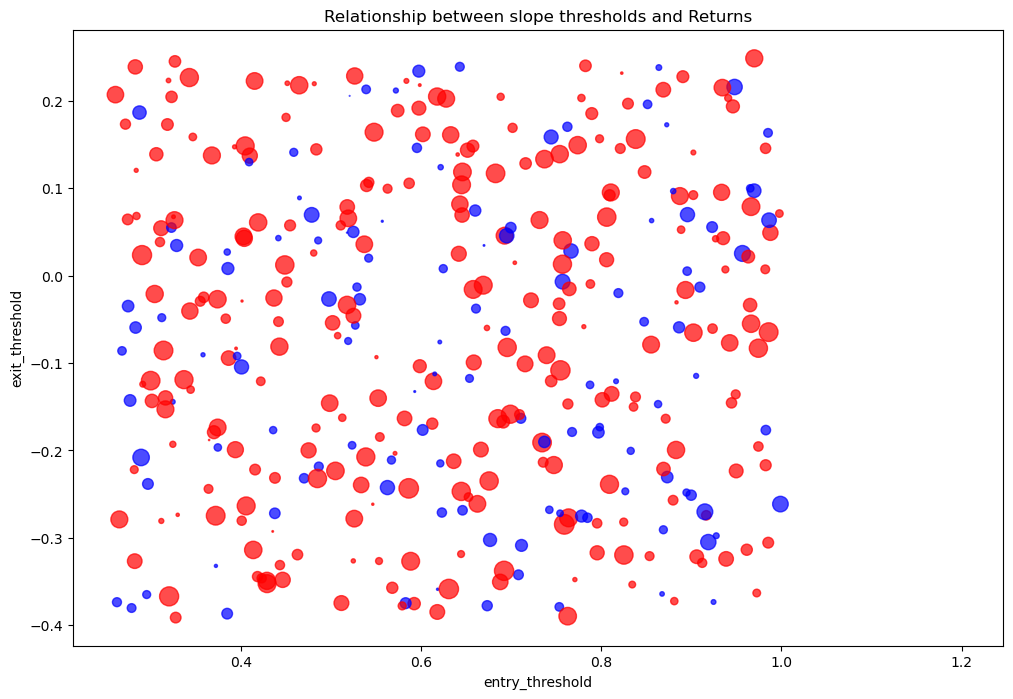

In [97]:
# Load the simulation results
with open('final_normalized_slope_simulation_results.json', 'r') as f:
    initial_simulation_results = json.load(f)

# Convert the results to a DataFrame
df = pd.DataFrame(initial_simulation_results)

# Create a column for colors (red for positive, blue for negative)
df['color'] = df['returns'].apply(lambda x: 'red' if x > 0 else 'blue')

# Create a column for size based on the absolute value of returns
df['size'] = df['returns'].abs() / df['returns'].abs().max() * 200  # Normalize sizes to range [0, 200]

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = plt.scatter(
    x=df['entry_threshold'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)

# Add labels and title
plt.title('Relationship between slope thresholds and Returns')
plt.xlabel('entry_threshold')
plt.ylabel('exit_threshold')

plt.show()

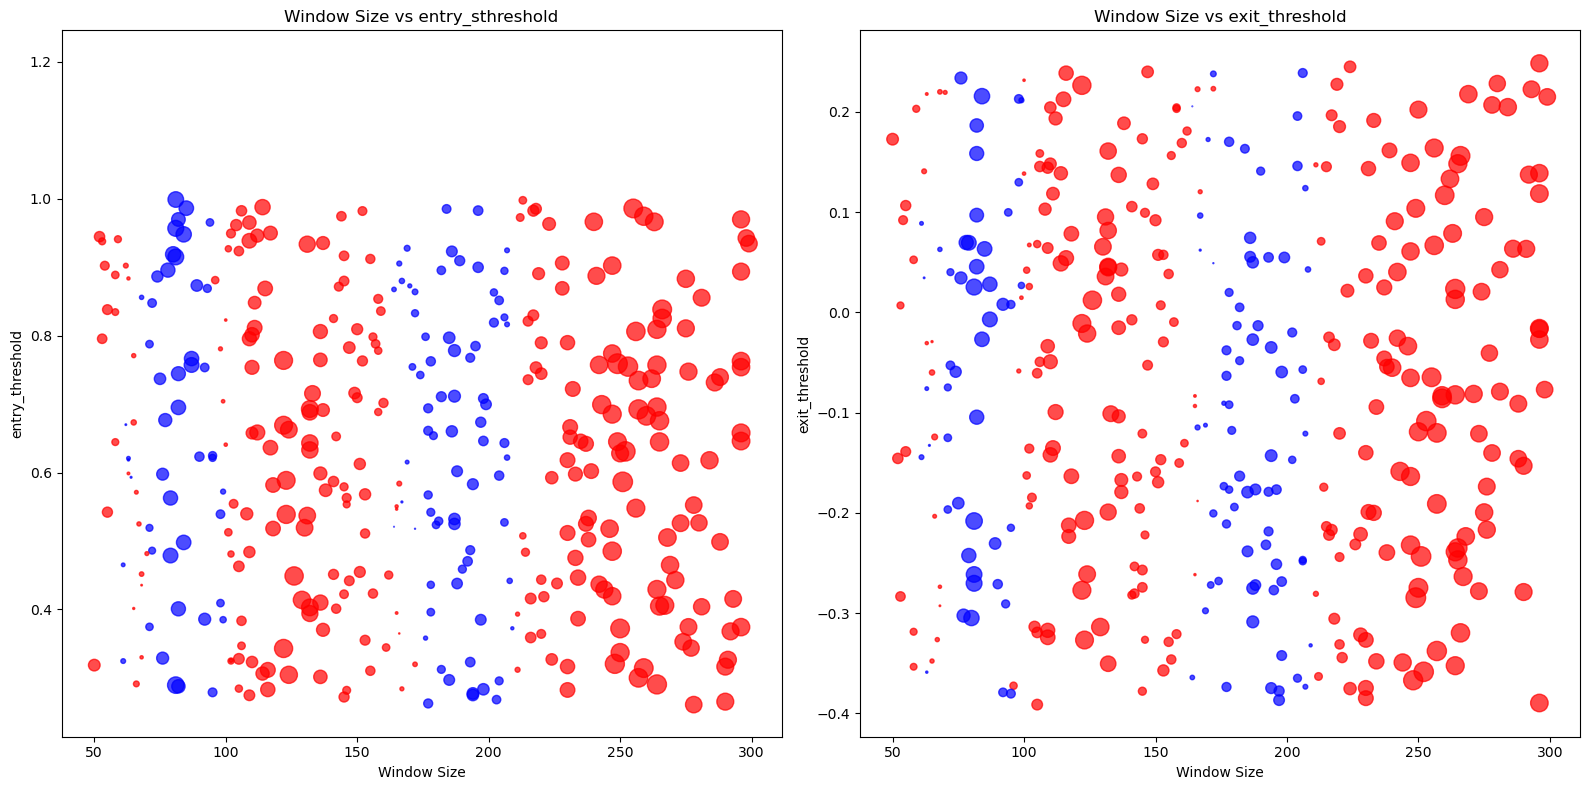

In [98]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# First scatter plot
scatter_plot1 = axes[0].scatter(
    x=df['window'],
    y=df['entry_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[0].set_title('Window Size vs entry_sthreshold')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('entry_threshold')

# Second scatter plot
scatter_plot2 = axes[1].scatter(
    x=df['window'],
    y=df['exit_threshold'],
    c=df['color'],  # Use the 'color' column for point colors
    s=df['size'],   # Use the 'size' column for point sizes
    alpha=0.7       # Add transparency for better visualization
)
axes[1].set_title('Window Size vs exit_threshold')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('exit_threshold')

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()


In [135]:
strategy = MomentumStrategy(pd.read_csv('data_new.csv').tail(5000), 50, 2000)
# Simulate trading
final_portfolio_value = strategy.simulate_trade_with_normalized_slope(
    market='LINKUSDT',
    position_size=1,
    entry_threshold=0.75,
    exit_threshold=-0.28,
    window=250
)

print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")

Final Portfolio Value: $2022.07


/var/folders/f4/h2v7b_cn2ns6mjck91vfz0_h0000gn/T/ipykernel_39115/3611664135.py:287: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.trade_logs_normalized[market] = pd.concat([self.trade_logs_normalized[market], new_row], ignore_index=True)


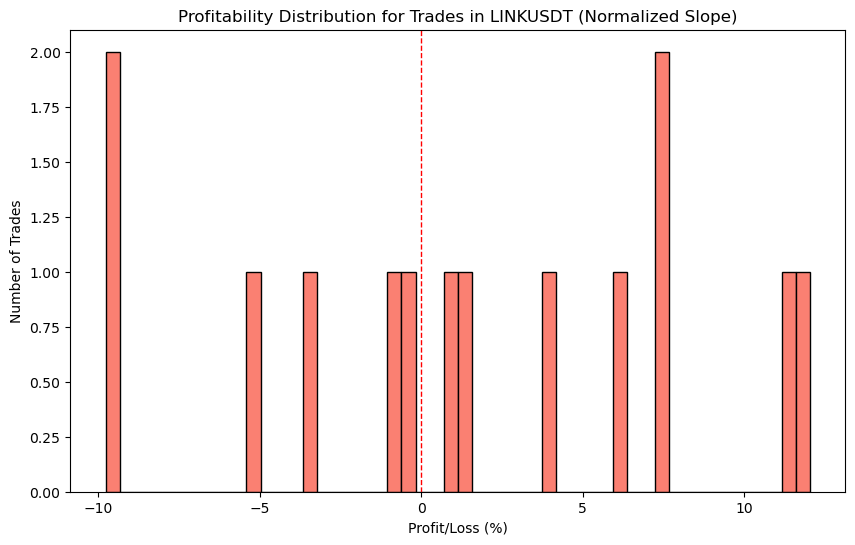

In [136]:
strategy.plot_trade_histogram_normalized('LINKUSDT', bins=50)